# Inferring iModulon activities for new data

Re-computing the complete set of iModulons can be computationally intensive for every new dataset. However, once a dataset reaches a critical size, you can use a pre-computed ``IcaData`` object to infer the iModulon activities of a new dataset. iModulon activities are relative measures; every dataset must have a reference condition to which all other samples are compared against.

To compute the new iModulon activities, first load the pre-computed ``IcaData`` object.

In [1]:
from pymodulon.example_data import load_ecoli_data
ica_data = load_ecoli_data()

Next, load your expression profiles. This should be normalized using whichever read mapping pipeline you use, as Transcripts per Million (TPM) or log-TPM.

In [2]:
from pymodulon.example_data import load_example_log_tpm
log_tpm = load_example_log_tpm()
log_tpm.head()

,Reference_1,Reference_2,Test_1,Test_2
Geneid,,,,
b0001,10.473721,10.271944,10.315476,10.808135
b0002,10.260569,10.368555,10.735874,10.726916
b0003,9.920277,10.044224,10.528432,10.503092
b0004,9.936694,10.010638,9.739519,9.722997
b0005,7.027515,7.237449,6.745798,6.497823


Next, make sure your dataset uses similar gene names as the target `IcaData` object.

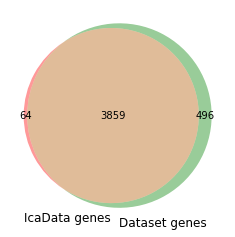

In [3]:
from matplotlib_venn import venn2
venn2((set(ica_data.gene_names),set(log_tpm.index)), set_labels=['IcaData genes','Dataset genes'])

Only genes shared between your ``IcaData`` object and the new expression profiles will be used to project your data. All other genes will be ignored.

Then, center your dataset on a reference condition, taking the average of replicates.

In [4]:
centered_log_tpm = log_tpm.sub(log_tpm[['Reference_1','Reference_2']].mean(axis=1),axis=0)
centered_log_tpm.head()

,Reference_1,Reference_2,Test_1,Test_2
Geneid,,,,
b0001,0.100889,-0.100889,-0.057356,0.435303
b0002,-0.053993,0.053993,0.421312,0.412354
b0003,-0.061973,0.061973,0.546181,0.520841
b0004,-0.036972,0.036972,-0.234147,-0.250669
b0005,-0.104967,0.104967,-0.386684,-0.634659


Finally, use the ``pymodulon.util.infer_activities`` function to infer the relative iModulon activities of your dataset.

In [5]:
from pymodulon.util import infer_activities

In [6]:
activities = infer_activities(ica_data,centered_log_tpm)
activities.head()

,Reference_1,Reference_2,Test_1,Test_2
AllR/AraC/FucR,0.243143,-0.243143,1.028044,0.848571
ArcA-1,-0.157687,0.157687,-2.644027,-2.418106
ArcA-2,0.038248,-0.038248,0.182260,0.039267
ArgR,-0.150147,0.150147,-1.456806,-1.293399
AtoC,0.344893,-0.344893,0.632130,1.075412


All of the plotting functions in ``pymodulon.plotting`` can be used on your inferred activities once you add it to a new ``IcaData`` object. It is advisable to create a new ``sample_table`` with ``project`` and ``condition`` columns.

In [7]:
from pymodulon.core import IcaData
import pandas as pd

In [8]:
new_sample_table = pd.DataFrame([['new_data','reference']]*2+[['new_data','test']]*2,columns=['project','condition'],index=log_tpm.columns)
new_sample_table

,project,condition
Reference_1,new_data,reference
Reference_2,new_data,reference
Test_1,new_data,test
Test_2,new_data,test


In [9]:
new_data = IcaData(ica_data.M,
                   activities,
                   gene_table = ica_data.gene_table,
                   sample_table = new_sample_table,
                   imodulon_table = ica_data.imodulon_table)

In [10]:
from pymodulon.plotting import *

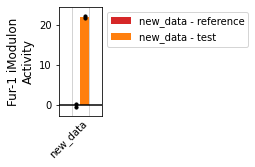

In [11]:
plot_activities(new_data,'Fur-1',highlight='new_data')